# Similarity Recommendation

* Collaborative Filtering
  * Similarity score is merchant similarity rank
  * Products list is most sold products in recent X weeks
    * Didn't choose most valuable products from `product_values` table is because they are largely overlapped with the top products in each merchant.
  * Avg daily purchase frequency is the count of each product in the list

In [1]:
import pandas as pd
import numpy as np
import datetime
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

In [2]:
import ray

ray.shutdown()

In [ ]:
ray.init()

In [4]:
target_merchant = '49th Parallel Grocery'

In [5]:
all_order_train = pd.read_pickle('../all_order_train.pkl')
all_order_test = pd.read_pickle('../all_order_test.pkl')
print(all_order_train.shape, all_order_test.shape)

all_order_train.head()

(33720820, 12) (98286, 12)


,order_id,user_id,order_number,order_hour_of_day,product_id,purchase_date,merchant,product_name,price,aisle,department,week_number
0,2539329,1,1,8,196,2019-02-13,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,7
1,2231262,31,17,11,196,2019-03-10,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
2,3058369,195,34,10,196,2019-02-25,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,9
3,2257155,951,3,20,196,2019-03-09,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
4,1121647,992,7,10,196,2019-03-08,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10


In [6]:
target_train = all_order_train.loc[all_order_train['merchant'] == target_merchant]
target_test = all_order_test.loc[all_order_test['merchant'] == target_merchant]

print(target_train.shape, target_test.shape)
target_train.head()

(1365312, 12) (3850, 12)


,order_id,user_id,order_number,order_hour_of_day,product_id,purchase_date,merchant,product_name,price,aisle,department,week_number
705698,2452257,7,20,9,47272,2019-04-04,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,14
705699,1867977,2850,19,10,47272,2019-03-14,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,11
705700,2879669,18719,1,23,47272,2019-02-23,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,8
705701,252427,38924,5,13,47272,2019-03-31,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,13
705702,1252985,55521,6,16,47272,2019-02-23,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,8


In [7]:
all_order_train = all_order_train.loc[all_order_train['merchant'] != target_merchant]
all_order_test = all_order_test.loc[all_order_test['merchant'] != target_merchant]

print(all_order_train.shape, all_order_test.shape)
all_order_train.head()

(32355508, 12) (94436, 12)


,order_id,user_id,order_number,order_hour_of_day,product_id,purchase_date,merchant,product_name,price,aisle,department,week_number
0,2539329,1,1,8,196,2019-02-13,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,7
1,2231262,31,17,11,196,2019-03-10,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
2,3058369,195,34,10,196,2019-02-25,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,9
3,2257155,951,3,20,196,2019-03-09,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
4,1121647,992,7,10,196,2019-03-08,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10


## Merchant Similarity Score

* Here, I converted the 3 similarity factors (top products, size, name) into 1 score, higher score represents higher similarity.
* Commapring with sorting by 3 factors, 1 similarity score brings a bit different results.

In [8]:
@ray.remote
def get_merchant_data(merchant_df, top=10):
    merchant_size = merchant_df[['merchant', 'product_id']].astype('str').drop_duplicates()\
                                                  .groupby(['merchant'], as_index=False)['product_id']\
                                                  .agg('count').reset_index(drop=True).T.to_dict()
    merchant_data = merchant_size[0]
    merchant_data['product_ct'] = merchant_data.pop('product_id')
    
    top_prod_lst_df = merchant_df[['product_id', 'order_id']].astype('str').drop_duplicates()\
                                        .groupby(['product_id'], as_index=False)['order_id']\
                                        .agg('count').reset_index(drop=True)\
                                        .sort_values(by='order_id', ascending=False)\
                                        .head(n=top)
    top_prod_lst = list(top_prod_lst_df['product_id'].values)
    
    merchant_data['top_prod_lst'] = top_prod_lst
    
    return merchant_data


@ray.remote
def get_merchant_similarity(target_merchant_dct, merchant_dct):
    prod_similarity = len(set(target_merchant_dct['top_prod_lst']).intersection(set(merchant_dct['top_prod_lst'])))
    size_similarity = abs(target_merchant_dct['product_ct'] - merchant_dct['product_ct'])
    name_similarity = Levenshtein.ratio(target_merchant_dct['merchant'], merchant_dct['merchant'])
    
    return {'merchant': merchant_dct['merchant'], 'prod_sim': prod_similarity, 'size_sim': size_similarity, 'name_sim': name_similarity}

In [9]:
target_merchant_train = get_merchant_data.remote(target_train[['merchant', 'product_id', 'order_id']], top=10)
target_merchant_dct = ray.get(target_merchant_train)

print(target_merchant_dct)

{'merchant': '49th Parallel Grocery', 'product_ct': 37655, 'top_prod_lst': ['24852', '13176', '21137', '21903', '47209', '47766', '47626', '16797', '26209', '27845']}


In [10]:
merchant_lst = all_order_train['merchant'].unique()

results = [get_merchant_data.remote(all_order_train.loc[all_order_train['merchant']==merchant][['merchant', 'product_id', 'order_id']]) 
           for merchant in merchant_lst]
merchant_data_lst = ray.get(results)

print(len(merchant_data_lst))
merchant_data_lst[7:9]

48


[{'merchant': 'North Central Co-op',
  'product_ct': 35920,
  'top_prod_lst': ['24852',
   '13176',
   '21137',
   '21903',
   '47209',
   '47766',
   '47626',
   '16797',
   '26209',
   '27966']},
 {'merchant': 'Nations Fresh Food',
  'product_ct': 24493,
  'top_prod_lst': ['24852',
   '13176',
   '21137',
   '21903',
   '47209',
   '47766',
   '47626',
   '27966',
   '16797',
   '27845']}]

In [11]:
results = [get_merchant_similarity.remote(target_merchant_train, merchant_dct) for merchant_dct in merchant_data_lst]
merchant_similarity_lst = ray.get(results)

merchant_similarity_df = pd.DataFrame(merchant_similarity_lst)
print(merchant_similarity_df.shape)

merchant_similarity_df = merchant_similarity_df.sort_values(by=['prod_sim', 'size_sim', 'name_sim'], ascending=[False, True, False])
merchant_similarity_df.head()

(48, 4)


,merchant,prod_sim,size_sim,name_sim
5,Avril (Health Supermarket),10,20,0.297872
15,Askew's Foods,10,80,0.176471
2,Coleman's,10,150,0.133333
4,Asian Food Centre,10,186,0.263158
10,Valu Foods,10,557,0.258065


In [12]:
prod_sim_min = min(merchant_similarity_df['prod_sim'])
prod_sim_max = max(merchant_similarity_df['prod_sim'])

size_sim_min = min(merchant_similarity_df['size_sim'])
size_sim_max = max(merchant_similarity_df['size_sim'])

print(prod_sim_min, prod_sim_max, size_sim_min, size_sim_max)

9 10 20 23859


In [13]:
def get_similarity_score(r):
    similarity = (r['prod_sim'] - prod_sim_min)/(prod_sim_max - prod_sim_min) * (size_sim_max - r['size_sim'])/(size_sim_max - size_sim_min) * r['name_sim']
    
    return round(similarity, 4)

In [14]:
merchant_similarity_df['similarity_score'] = merchant_similarity_df.apply(get_similarity_score, axis=1)
merchant_similarity_df = merchant_similarity_df.sort_values(by='similarity_score', ascending=False)

merchant_similarity_df.head()

,merchant,prod_sim,size_sim,name_sim,similarity_score
1,Fairway Markets,10,1177,0.333333,0.3172
5,Avril (Health Supermarket),10,20,0.297872,0.2979
4,Asian Food Centre,10,186,0.263158,0.2613
10,Valu Foods,10,557,0.258065,0.2523
23,Fresh City Market,10,3535,0.263158,0.2244


## Recent Popular Products

Excluding top products of the target merchant.

In [15]:
all_order_train.head()

,order_id,user_id,order_number,order_hour_of_day,product_id,purchase_date,merchant,product_name,price,aisle,department,week_number
0,2539329,1,1,8,196,2019-02-13,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,7
1,2231262,31,17,11,196,2019-03-10,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
2,3058369,195,34,10,196,2019-02-25,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,9
3,2257155,951,3,20,196,2019-03-09,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
4,1121647,992,7,10,196,2019-03-08,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10


In [16]:
latest_period = 2  # in weeks
week_lst = sorted(all_order_train['week_number'].unique())[-latest_period:]
week_lst

[20, 21]

In [17]:
prod_ct_df = all_order_train.loc[all_order_train['week_number'].isin(week_lst)][['product_id', 'product_name', 'order_id']].astype('str').drop_duplicates()\
                                        .groupby(['product_id', 'product_name'], as_index=False)['order_id']\
                                        .agg('count').reset_index(drop=True)\
                                        .sort_values(by='order_id', ascending=False)

# remove product_id that's in target merchant's top popular products
prod_ct_df = prod_ct_df.loc[~prod_ct_df['product_id'].isin(target_merchant_dct['top_prod_lst'])]
prod_ct_df.head()

,product_id,product_name,order_id
18505,49683,Cucumber Kirby,715
7009,24964,Organic Garlic,693
8423,27966,Organic Raspberries,688
6098,22935,Organic Yellow Onion,642
13740,39275,Organic Blueberries,595


In [18]:
n = 20
product_lst = prod_ct_df['product_id'].values[:n]
print(product_lst)
print()
print(prod_ct_df['product_name'].values[:n])

['49683' '24964' '27966' '22935' '39275' '45007' '28204' '4605' '42265'
 '44632' '5876' '4920' '40706' '30391' '30489' '8518' '27104' '45066'
 '5077' '17794']

['Cucumber Kirby' 'Organic Garlic' 'Organic Raspberries'
 'Organic Yellow Onion' 'Organic Blueberries' 'Organic Zucchini'
 'Organic Fuji Apple' 'Yellow Onions' 'Organic Baby Carrots'
 'Sparkling Water Grapefruit' 'Organic Lemon' 'Seedless Red Grapes'
 'Organic Grape Tomatoes' 'Organic Cucumber' 'Original Hummus'
 'Organic Red Onion' 'Fresh Cauliflower' 'Honeycrisp Apple'
 '100% Whole Wheat Bread' 'Carrots']


## Collaborative Filtering

In [19]:
merchant_similarity_df.head()

,merchant,prod_sim,size_sim,name_sim,similarity_score
1,Fairway Markets,10,1177,0.333333,0.3172
5,Avril (Health Supermarket),10,20,0.297872,0.2979
4,Asian Food Centre,10,186,0.263158,0.2613
10,Valu Foods,10,557,0.258065,0.2523
23,Fresh City Market,10,3535,0.263158,0.2244


In [20]:
all_order_train.head()

,order_id,user_id,order_number,order_hour_of_day,product_id,purchase_date,merchant,product_name,price,aisle,department,week_number
0,2539329,1,1,8,196,2019-02-13,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,7
1,2231262,31,17,11,196,2019-03-10,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
2,3058369,195,34,10,196,2019-02-25,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,9
3,2257155,951,3,20,196,2019-03-09,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
4,1121647,992,7,10,196,2019-03-08,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10


In [21]:
n_merchant = 10
similar_merchant_lst = merchant_similarity_df['merchant'].values[:n_merchant]
merchant_similarity_lst = merchant_similarity_df['similarity_score'].values[:n_merchant]

@ray.remote
def get_product_score(prod_df, product_id, product_name):
    total_weighted_frequency = 0.0
    total_similarity = 0.0
    
    for i in range(len(similar_merchant_lst)):
        merchant = similar_merchant_lst[i]
        tmp_df = prod_df.loc[prod_df['merchant']==merchant]
        if tmp_df.shape[0] > 0:
            daily_avg = tmp_df['order_id'].nunique()/tmp_df['purchase_date'].nunique()
            similarity = merchant_similarity_lst[i]
            
            total_similarity += similarity
            total_weighted_frequency += similarity * daily_avg
    prod_score = total_weighted_frequency/total_similarity
    
    return {'product_id': product_id, 'product_name': product_name, 'prod_score': round(prod_score, 4)}

In [22]:
prod_score_lst = [get_product_score.remote(all_order_train.loc[all_order_train['product_id']==int(product_lst[i])][['merchant', 'order_id', 'purchase_date']],
                                           product_lst[i], prod_ct_df['product_name'].values[i])
                  for i in range(len(product_lst))]

In [23]:
prod_score_df = pd.DataFrame(ray.get(prod_score_lst))
prod_score_df = prod_score_df.sort_values(by='prod_score', ascending=False)
prod_score_df

,product_id,product_name,prod_score
2,27966,Organic Raspberries,46.7139
3,22935,Organic Yellow Onion,38.9308
1,24964,Organic Garlic,37.5127
5,45007,Organic Zucchini,36.3389
4,39275,Organic Blueberries,34.9509
0,49683,Cucumber Kirby,32.7733
6,28204,Organic Fuji Apple,30.8378
10,5876,Organic Lemon,30.6843
12,40706,Organic Grape Tomatoes,29.5666
13,30391,Organic Cucumber,28.6265


## Forecasting Recommendations

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# the logger here is to remove the warnings about plotly
import logging
logger = logging.getLogger('fbprophet.plot')
logger.setLevel(logging.CRITICAL)
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [25]:
sample_train_df1 = pd.read_pickle('../sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('../sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

(100, 2) (14, 2)


In [26]:
train1_col = sample_train_df1['purchase_amount']
test1_col = sample_test_df1['purchase_amount']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean()

ts_moving_avg_train1.head(n=10)

purchase_date
2019-02-11          NaN
2019-02-12          NaN
2019-02-13          NaN
2019-02-14    11.336649
2019-02-15    11.574900
2019-02-16    11.823810
2019-02-17    12.072987
2019-02-18    12.329429
2019-02-19    12.547873
2019-02-20    12.668333
Name: purchase_amount, dtype: float64

In [27]:
ts_ma_train1 = pd.DataFrame(ts_moving_avg_train1.copy())
ts_ma_train1['ds'] = ts_ma_train1.index
ts_ma_train1['y'] = ts_moving_avg_train1.values
ts_ma_train1.drop(['purchase_amount'], inplace=True, axis=1)
print(ts_ma_train1.shape)

ts_ma_test1 = pd.DataFrame(ts_moving_avg_test1.copy())
ts_ma_test1['ds'] = ts_ma_test1.index
ts_ma_test1['y'] = ts_moving_avg_test1.values
ts_ma_test1.drop(['purchase_amount'], inplace=True, axis=1)
print(ts_ma_test1.shape)

ts_ma_train1.head()

(100, 2)
(14, 2)


,ds,y
purchase_date,,
2019-02-11,2019-02-11,NaN
2019-02-12,2019-02-12,NaN
2019-02-13,2019-02-13,NaN
2019-02-14,2019-02-14,11.336649
2019-02-15,2019-02-15,11.574900


In [28]:
latest_period = 14
forecast_period = 7

train = ts_ma_train1.tail(n=latest_period)
test = ts_ma_test1.head(n=forecast_period)

print(train.shape, test.shape)

train.head()

(14, 2) (7, 2)


,ds,y
purchase_date,,
2019-05-08,2019-05-08,10.493818
2019-05-09,2019-05-09,10.377655
2019-05-10,2019-05-10,10.238874
2019-05-11,2019-05-11,10.085350
2019-05-12,2019-05-12,9.989850


In [29]:
prophet_model = Prophet(daily_seasonality = True, yearly_seasonality=False, weekly_seasonality=False,
                            seasonality_mode = 'multiplicative', n_changepoints=5,
                            changepoint_prior_scale=0.05, seasonality_prior_scale=0.1)
prophet_model.fit(train)
    
periods = len(test.index)
future = prophet_model.make_future_dataframe(periods=periods)
forecast = prophet_model.predict(future)

print(train.shape, test.shape, forecast.shape)
all_ts = train.append(test).dropna()
selected_forecast = forecast.loc[forecast['ds'].isin(all_ts.index)]
rmse = round(sqrt(mean_squared_error(all_ts['y'].values, selected_forecast['yhat'].values)), 4)
print(rmse)

forecast.head()

(14, 2) (7, 2) (21, 16)
0.0391


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-05-08,9.590014,10.470522,10.521577,9.590014,9.590014,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,10.495194
1,2019-05-09,9.472009,10.340789,10.391986,9.472009,9.472009,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,10.366051
2,2019-05-10,9.354004,10.210833,10.260998,9.354004,9.354004,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,10.236907
3,2019-05-11,9.237804,10.086179,10.135653,9.237804,9.237804,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,10.109740
4,2019-05-12,9.121605,9.957219,10.007643,9.121605,9.121605,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,9.982573


In [30]:
exp_forecast = forecast[['ds', 'yhat']]
exp_forecast['y_origin'] = np.exp(exp_forecast['yhat'])
exp_forecast.head()

,ds,yhat,y_origin
0,2019-05-08,10.495194,36141.391045
1,2019-05-09,10.366051,31762.786848
2,2019-05-10,10.236907,27914.659597
3,2019-05-11,10.109740,24581.269973
4,2019-05-12,9.982573,21645.932360


(21, 1)


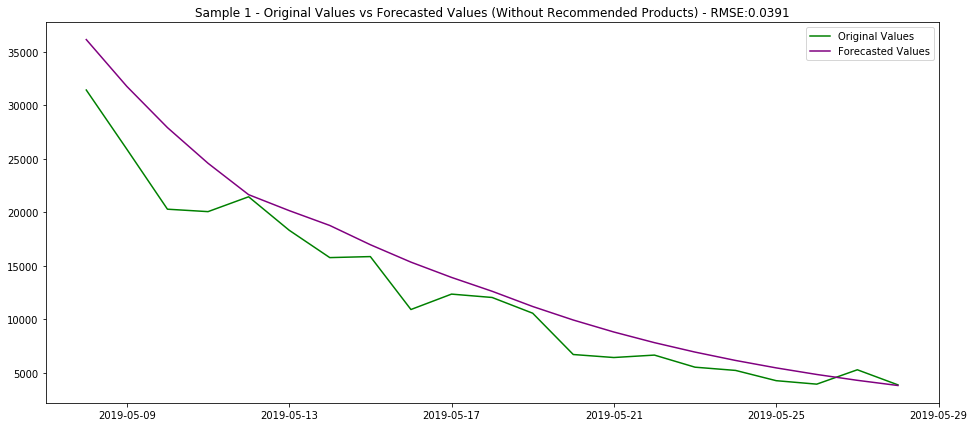

In [31]:
original_ts = sample_train_df1.iloc[sample_train_df1.index.isin(train.index)][['purchase_amount']]
original_ts = original_ts.append(sample_test_df1.iloc[sample_test_df1.index.isin(test.index)][['purchase_amount']])
print(original_ts.shape)

plt.figure(figsize=(16,7))
plt.plot(original_ts.index, original_ts, label='Original Values', color='green')
plt.plot(exp_forecast['ds'], exp_forecast['y_origin'].values, label='Forecasted Values', color='purple')
plt.legend(loc='best')
plt.title("Sample 1 - Original Values vs Forecasted Values (Without Recommended Products) - RMSE:" + str(rmse))
plt.show()

In [42]:
product_values_df = pd.read_pickle('product_values.pkl')
product_values_df.head()

,product_id,total_popularity,product_value,avg_daily_sales,product_name
0,24852,6935.67,31742.000,21.52,Banana
1,13176,5385.83,12622.375,12.05,Bag of Organic Bananas
2,21137,3708.33,6519.100,9.38,Organic Strawberries
3,21903,3537.39,15351.590,20.62,Organic Baby Spinach
4,47209,3003.98,6164.910,10.62,Organic Hass Avocado


In [49]:
product_values_df['product_id'] = product_values_df['product_id'].astype(str)
prod_score_sales_df = prod_score_df.merge(product_values_df[['product_id', 'avg_daily_sales']], on='product_id')

prod_score_sales_df.head()

,product_id,product_name,prod_score,avg_daily_sales
0,27966,Organic Raspberries,46.7139,18.37
1,22935,Organic Yellow Onion,38.9308,28.55
2,24964,Organic Garlic,37.5127,29.87
3,45007,Organic Zucchini,36.3389,9.99
4,39275,Organic Blueberries,34.9509,20.48


In [54]:
test_ct = 20
daily_sales_increase = 0

original_ts = sample_train_df1.iloc[sample_train_df1.index.isin(train.index)][['purchase_amount']]
original_ts = original_ts.append(sample_test_df1.iloc[sample_test_df1.index.isin(test.index)][['purchase_amount']])
print(original_ts.shape)

exp_forecast['y_forecast'] = exp_forecast['y_origin']
forecast_ts_train = exp_forecast.head(n=latest_period)
forecast_ts_test = exp_forecast.tail(n=forecast_period)

for idx, r in prod_score_sales_df.iterrows():
    added_daily_sales = r['avg_daily_sales']
    forecast_ts_test['y_forecast'] += added_daily_sales
    
    daily_sales_increase += added_daily_sales
    
    if idx >= test_ct:
        break

(21, 1)


Total sales increased: 2162.51


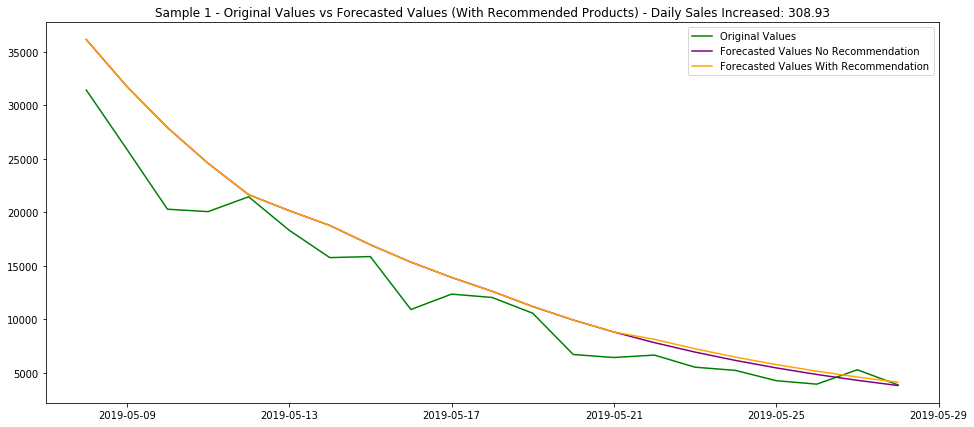

In [55]:
forecast_ts = forecast_ts_train.append(forecast_ts_test)
print('Total sales increased: ' + str(daily_sales_increase * forecast_period))

plt.figure(figsize=(16,7))
plt.plot(original_ts.index, original_ts, label='Original Values', color='green')
plt.plot(exp_forecast['ds'], exp_forecast['y_origin'].values, label='Forecasted Values No Recommendation', color='purple')
plt.plot(forecast_ts['ds'], forecast_ts['y_forecast'].values, label='Forecasted Values With Recommendation', color='orange')
plt.legend(loc='best')
plt.title("Sample 1 - Original Values vs Forecasted Values (With Recommended Products) - Daily Sales Increased: " + str(daily_sales_increase))
plt.show()

## Summary

* If we recommend the top 7 products as popularity_recommendation method, the daily increase in this method is still higher.
* If we want the forecasting curve obvious, mainly need to increase the number of recommended products.